<a href="https://colab.research.google.com/github/heoge/temp_repo/blob/main/w10/image_segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with a pretrained model: Segment Anything

Segment Anything is a powerful pretrained segmentation model you can use for, well, almost anything. It was developed by Meta AI and released in April 2023. It was trained on 11 million diverse images and their segmentation masks, covering over one billion object instances. This massive amount of training data provides the model with built-in knowledge of virtually any object that appears in natural images.

In [1]:
import keras
import matplotlib.pyplot as plt

Prepare a test image :)

259153/259153 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


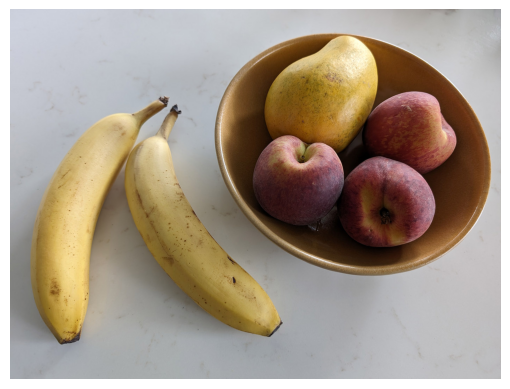

In [2]:
path =keras.utils.get_file(origin="https://s3.amazonaws.com/keras.io/img/book/fruits.jpg") #1
pil_image = keras.utils.load_img(path) #2
image_array = keras.utils.img_to_array(pil_image) #3
plt.imshow(image_array.astype("uint8")) #4
plt.axis("off")
plt.show()

'#1 Download the image and return the local file path  
'#2 Load the imageas a PIL (Python Imaging Library) object  
'#3 Turn the PIL object into a NumPy matrix  
'#4 Display the NumPy matrix  

The Segment Anything model expects inputs that are 1024 x 1024. However, forcibly
resizing arbitrary images to 1024 x 1024 would distort their aspect ratio – for instance, our
image isn’t square. It’s better to first resize the image so that its longest side becomes
1024 pixels long, and then pad with the remaining pixels with a filler value, such as 0.

In [3]:
from keras import ops
image_size = (1024, 1024)
def resize_and_pad(x):
  return ops.image.resize(x, image_size, pad_to_aspect_ratio=True)
image = resize_and_pad(image_array)

## Get the pretrained SAM model

In [4]:
import keras_hub
model = keras_hub.models.SAMImageSegmenter.from_preset("sam_huge_sa1b")

100%|██████████| 3.06k/3.06k [00:00<00:00, 3.75MB/s]


100%|██████████| 5.77k/5.77k [00:00<00:00, 1.46MB/s]


100%|██████████| 2.39G/2.39G [00:46<00:00, 54.7MB/s]


100%|██████████| 2.39G/2.39G [00:48<00:00, 52.5MB/s]


Let’s define a few utilities that will come in handy when using the model.   

We’re going to need to:  
- Display images.
- Display segmentation masks overlaid on an image.
- Highlight specific points on an image.
- Display boxes overlaid on an image.

In [5]:
import matplotlib.pyplot as plt
from keras import ops

def show_image(image, ax):
  ax.imshow(ops.convert_to_numpy(image).astype("uint8"))

def show_mask(mask, ax):
  color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
  h, w, _ = mask.shape
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels == 1]
  neg_points = coords[labels == 0]
  ax.scatter(
    pos_points[:, 0],
    pos_points[:, 1],
    color="green",
    marker="*",
    s=marker_size,
    edgecolor="white",
    linewidth=1.25,
  )
  ax.scatter(
    neg_points[:, 0],
    neg_points[:, 1],
    color="red",
    marker="*",
    s=marker_size,
    edgecolor="white",
    linewidth=1.25,
  )

def show_box(box, ax):
  box = box.reshape(-1)
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(
    plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
  )

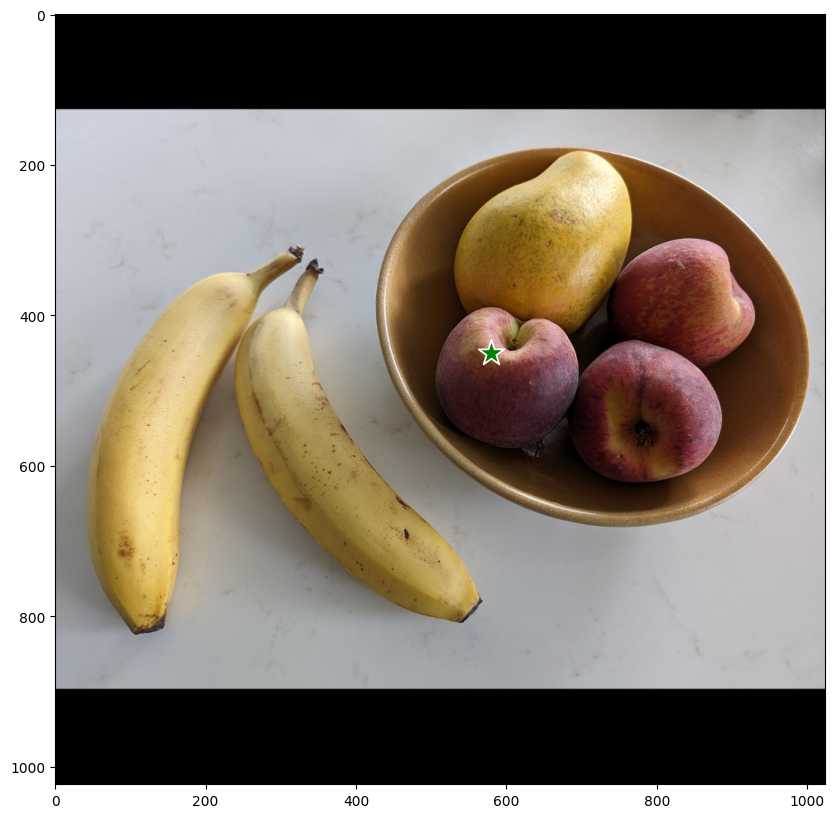

In [6]:
import numpy as np
input_point = np.array([[580, 450]]) #1
input_label = np.array([1]) #2
plt.figure(figsize=(10, 10))
show_image(image, plt.gca()) #3
show_points(input_point, input_label, plt.gca())
plt.show()

`#1 Coordinates of our point   

`#2 1 means foreground, and 0 means background.   

`#3 “gca” means “get current axis” – the current figure

Let’s prompt SAM with it:

In [7]:
outputs = model.predict(
{
"images": ops.expand_dims(image, axis=0),
"points": ops.expand_dims(input_point, axis=0),
"labels": ops.expand_dims(input_label, axis=0),
}
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step


The return value outputs has a "masks" field which contains four 256x256 candidate
masks for the target object, ranked by decreasing match quality. The quality scores of the
masks are available under the "iou_pred" field as part of the model’s output.

In [8]:
outputs["masks"].shape

(1, 4, 256, 256)

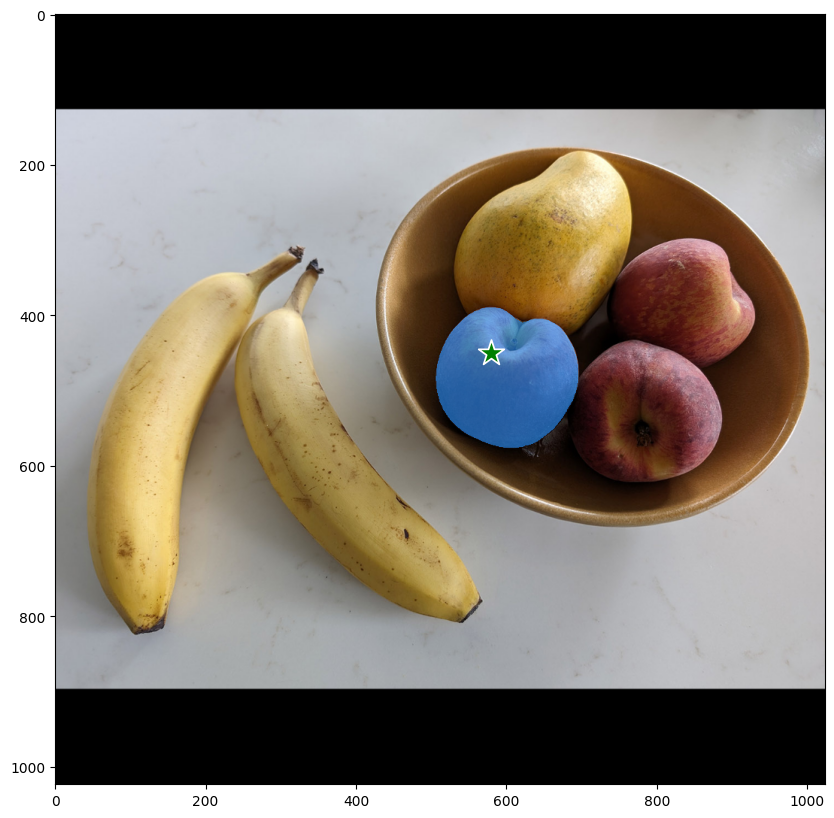

In [9]:
def get_mask(sam_outputs, index=0):
  mask = outputs["masks"][0][index]
  mask = np.expand_dims(mask, axis=-1)
  mask = resize_and_pad(mask)
  return ops.convert_to_numpy(mask) > 0.0

mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()

Next: let’s try a banana. We’ll prompt the model with coordinates (300, 550), which
land on the second banana from the left.

1/1 ━━━━━━━━━━━━━━━━━━━━ 225s 225s/step


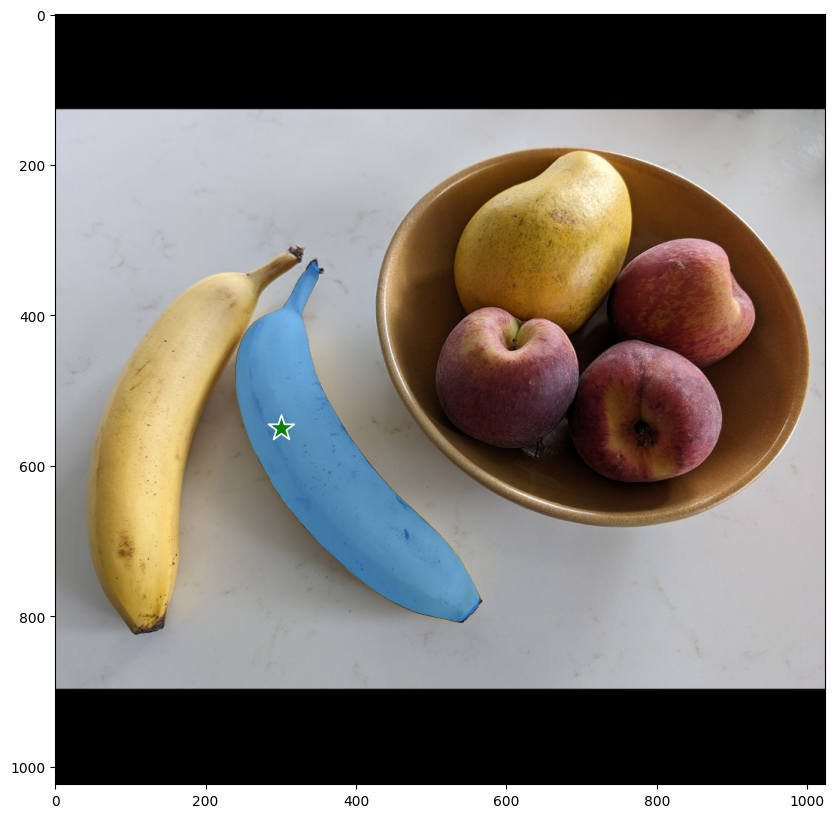

In [10]:
input_point = np.array([[300, 550]])
input_label = np.array([1])
outputs = model.predict(
  {
    "images": ops.expand_dims(image, axis=0),
    "points": ops.expand_dims(input_point, axis=0),
    "labels": ops.expand_dims(input_label, axis=0),
  }
)
mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()

what about the other mask candidates? Those can come in handy for ambigious
prompts. Let’s try to plot the other three masks.

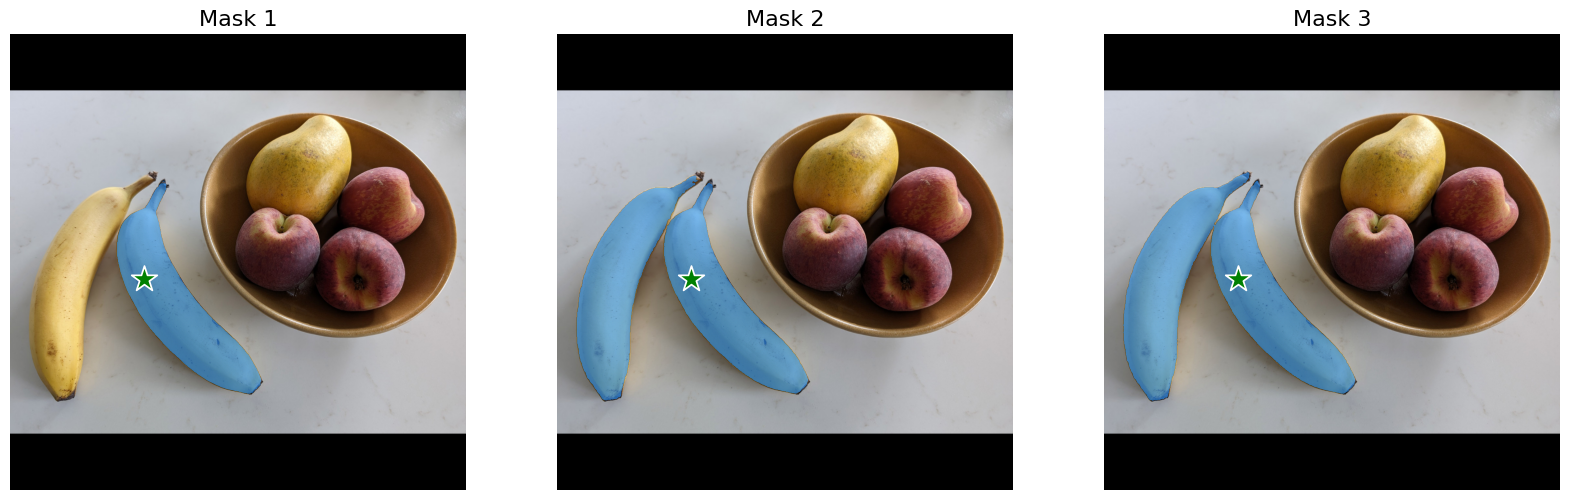

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 60))
masks = outputs["masks"][0][1:]
for i, mask in enumerate(masks):
  show_image(image, axes[i])
  show_points(input_point, input_label, axes[i])
  mask = get_mask(outputs, index=i + 1)
  show_mask(mask, axes[i])
  axes[i].set_title(f"Mask {i+1}", fontsize=16)
  axes[i].axis("off")
plt.show()

## PROMPTING SAM WITH A TARGET BOX

Besides providing one or more target points, you can also provide boxes approximating the
location of the object to segment. These boxes should be passed via the coordinates of
their top left and bottom right corners.

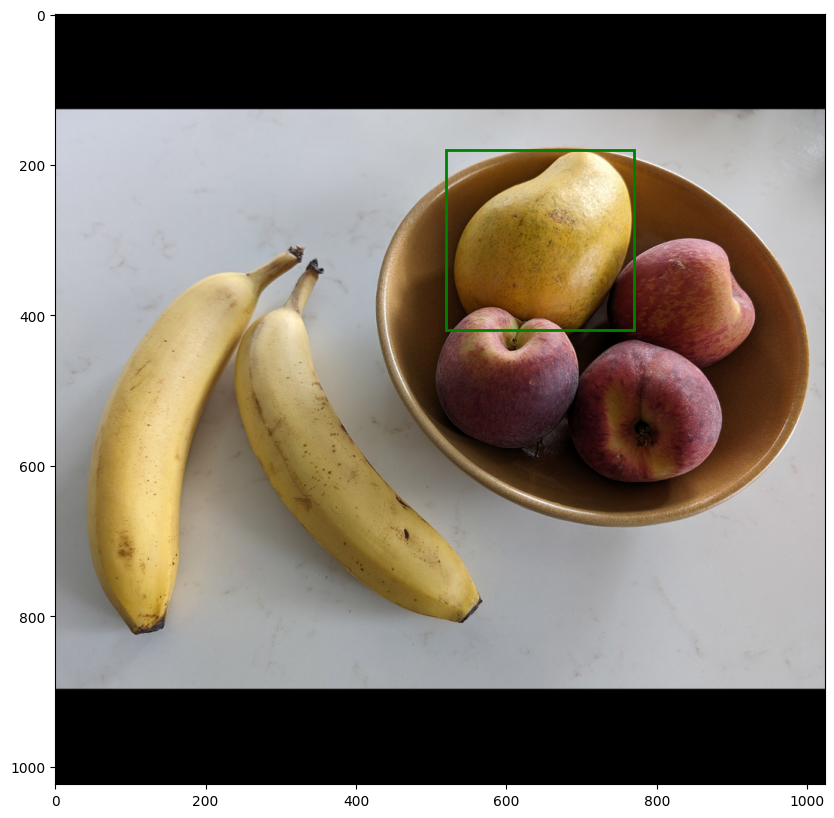

In [12]:
input_box = np.array(
  [[520, 180], #1
  [770, 420]], #2
)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_box(input_box, plt.gca())
plt.show()

`#1 Top left corner  

`#2 Bottom right corner  


Let’s prompt SAM with it:

1/1 ━━━━━━━━━━━━━━━━━━━━ 233s 233s/step


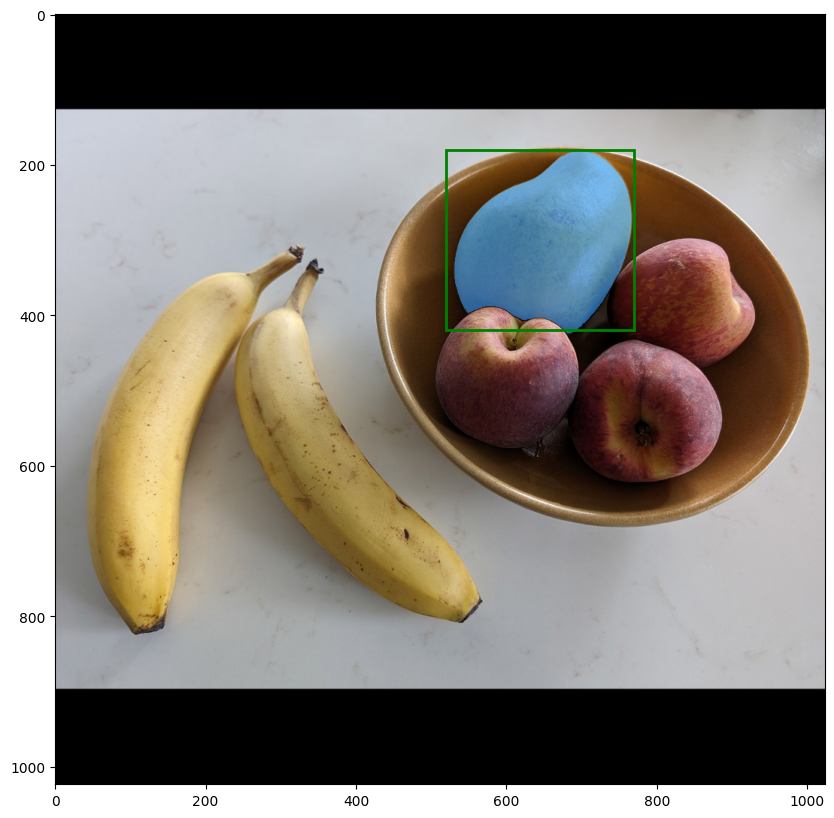

In [13]:
outputs = model.predict(
  {"images": ops.expand_dims(image, axis=0), "boxes": ops.expand_dims(input_box, axis=
  (0, 1))}
)
mask = get_mask(outputs, 0)
plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.show()